# Q2

#### part a
Traditional Convolution (Regular Grid):
Fixed and regular grid sampling.
The filter is applied to the input data at evenly spaced positions.
Limited adaptability to capture deformable structures or patterns.

Deformable Convolution (Flexible Grid):
Dynamic and flexible grid sampling.
Learnable offsets determine the adjustments to the sampling positions for each position in the output feature map.
Greater adaptability to capture complex spatial relationships, including deformations.

#### part b
Traditional Convolution: Limited ability to handle deformations in objects or patterns.

Deformable Convolution: Better suited for capturing deformable structures and variations in data.

Deformable convolutions introduce learnable parameters called "offsets" for each position in the output feature map.
These offsets are learned during the training process and determine how the sampling positions should be adjusted for each spatial location in the output feature map.
The dynamic adjustment of sampling positions enables the model to capture deformations in objects or patterns.
If an object undergoes a geometric transformation, the deformable convolution can adjust its sampling locations to better align with the deformed structure, improving the model's ability to recognize and understand the transformed objects.

#### part c
Traditional Convolution: Static and rigid in terms of sampling positions.

Deformable Convolution: Adapts to the local context, enhancing the model's ability to learn more complex spatial relationships.


deformable convolutions introduce a level of adaptability that traditional convolutions lack, making them particularly useful in tasks where objects or patterns may undergo deformations or where more flexible modeling of spatial relationships is required. The deformable convolutional layers have been shown to be effective in computer vision tasks such as object detection and segmentation.

#### part d
The offsets are obtained by applying a convolutional layer over the same input feature map. During training, both the convolutional kernels for generating the output features and the offsets are learned simultaneously. To learn the offsets, the gradients are backpropagated through a bilinear interpolation of its equations.


# implementation

### import required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
# pytorch
import torchvision.models as models
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, Tensor
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Function
from torchvision.models import alexnet
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR10
from typing import Optional, Tuple

### Data preprocessing and enhancement (CIFAR10 dataset)

In [2]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    # transforms.RandomHorizontalFlip()
    # transforms.RandomGrayscale()
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

trainset = CIFAR10(root='./cifar10', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = CIFAR10(root='./cifar10', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

classDict = {'airplane': 0, 'car': 1, 'bird': 2, 'cat': 3, 'deer': 4,
             'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

def my_pair(x):
    if isinstance(x, (list, tuple)):
        if len(x) == 1:
            return x[0], x[0]
        elif len(x) == 2:
            return x
        else:
            raise ValueError("Expected a list or tuple of length 1 or 2, but got {}".format(x))
    else:
        return x, x

100%|██████████| 170498071/170498071 [00:03<00:00, 54935939.85it/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


In [3]:
class Traditional_CNN(nn.Module):
    def __init__(self):
        super(Traditional_CNN, self).__init__()

        self.seq = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)),
        )

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.seq(x)
        x = self.flatten(x)
        x = self.softmax(self.fc1(x))
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Instantiate the model
traditional_model = Traditional_CNN()
traditional_model = traditional_model.to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(traditional_model.parameters(), lr=0.001)

In [4]:
# Record the start time
start_time = time.time()
# Training loop
epochs = 15
train_loss_1 = []
train_acc_1 = []
test_loss_1 = []
test_acc_1 = []
for epoch in range(epochs):
    running_loss = []
    traditional_model.train()
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = traditional_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        correct = 0
        samples_num = 0
        with torch.no_grad():
            y_pred = torch.argmax(outputs, dim=1)
            correct += (y_pred == labels).sum().item()
            samples_num += labels.size(0)
            running_loss.append(loss.cpu().detach().numpy())

    epoch_loss = np.mean(running_loss)
    epoch_accuracy =  correct / samples_num
    test_correct = 0
    test_samples_num = 0
    running_loss_test = []
    traditional_model.eval()
    with torch.no_grad():
        for x_test, y_test in testloader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            y_pred = traditional_model(x_test)
            loss = criterion(y_pred, y_test)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y_test).sum().item()
            test_samples_num += y_test.size(0)
            running_loss_test.append(loss.cpu().detach().numpy())

    epoch_test_loss = np.mean(running_loss_test)
    epoch_test_acc = test_correct / test_samples_num

    print(f'epoch: {epoch+1}, train loss：{epoch_loss:.5}, train accuracy: {epoch_accuracy:.3%}, test loss：{epoch_test_loss:.5}, test accuracy: {epoch_test_acc:.3%}')
    train_loss_1.append(epoch_loss)
    train_acc_1.append(epoch_accuracy)
    test_loss_1.append(epoch_test_loss)
    test_acc_1.append(epoch_test_acc)
# Record the end time
end_time = time.time()

# Calculate and print the training runtime
training_time = end_time - start_time
print(f"Training Runtime: {training_time:.2f} seconds")

epoch: 1, train loss：2.1737, train accuracy: 50.000%, test loss：2.0943, test accuracy: 36.260%
epoch: 2, train loss：2.0811, train accuracy: 31.250%, test loss：2.0698, test accuracy: 38.260%
epoch: 3, train loss：2.0379, train accuracy: 75.000%, test loss：2.0181, test accuracy: 43.510%
epoch: 4, train loss：2.011, train accuracy: 50.000%, test loss：2.0044, test accuracy: 45.100%
epoch: 5, train loss：1.9889, train accuracy: 43.750%, test loss：1.9848, test accuracy: 46.940%
epoch: 6, train loss：1.9666, train accuracy: 43.750%, test loss：1.9622, test accuracy: 49.760%
epoch: 7, train loss：1.9448, train accuracy: 56.250%, test loss：1.9342, test accuracy: 52.360%
epoch: 8, train loss：1.9271, train accuracy: 37.500%, test loss：1.9257, test accuracy: 53.270%
epoch: 9, train loss：1.9102, train accuracy: 50.000%, test loss：1.9288, test accuracy: 52.930%
epoch: 10, train loss：1.8965, train accuracy: 75.000%, test loss：1.9093, test accuracy: 54.860%
epoch: 11, train loss：1.8827, train accuracy: 62.5

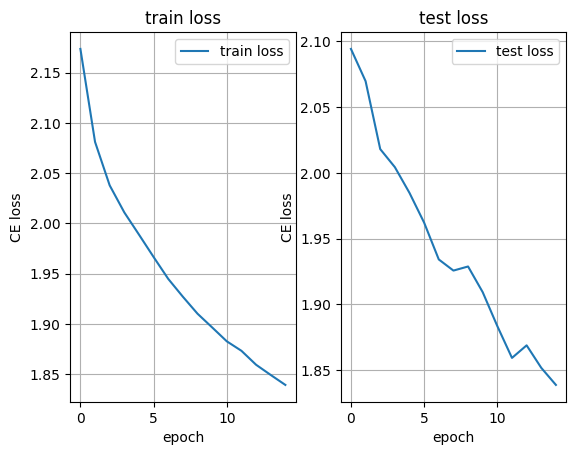

In [5]:
fig, axs = plt.subplots(1, 2)
axs[0].set_title('train loss')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('CE loss')
axs[0].grid(True)
axs[0].plot(train_loss_1, label='train loss')
axs[0].legend()
axs[1].set_title('test loss')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('CE loss')
axs[1].grid(True)
axs[1].plot(test_loss_1, label='test loss')
axs[1].legend()

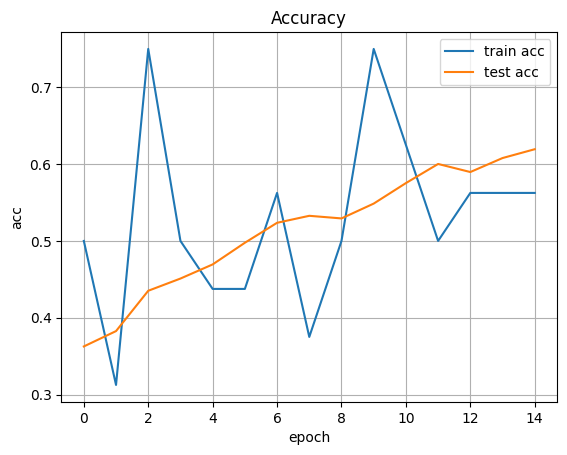

In [6]:
plt.figure(2)
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.grid(True)
plt.plot(train_acc_1, label='train acc')
plt.plot(test_acc_1, label='test acc')
plt.legend()

In [7]:
class DeformableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, deformable_groups=1):
        super(DeformableConv2d, self).__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation)
        self.kernel_size = my_pair(kernel_size)
        self.offset_conv = nn.Conv2d(in_channels, deformable_groups * 2 * self.kernel_size[0] * self.kernel_size[1], kernel_size, stride, padding, dilation)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.padding = my_pair(padding)
        self.stride = my_pair(stride)
        self.dilation = my_pair(dilation)
        self.deformable_groups = deformable_groups
        self.weight = nn.Parameter(torch.Tensor(out_channels, in_channels, *self.kernel_size))
        self.reset_parameters()

    def reset_parameters(self) -> None:
        nn.init.kaiming_uniform_(self.weight, a=np.sqrt(5))

    def forward(self, x: Tensor, mask: Optional[Tensor] = None):
        offset = self.offset_conv(x)
        batch_size, C, H, W = offset.size()
        offset = offset.view(batch_size, self.deformable_groups, 2 * self.kernel_size[0] * self.kernel_size[1], H, W)

        # Reshape offset to (batch_size, deformable_groups * 2 * kernel_size[0] * kernel_size[1], H, W)
        offset = offset.permute(0, 2, 3, 4, 1).contiguous().view(batch_size, -1, H, W)

        # Apply deformable convolution
        
        use_mask = mask is not None

        if mask is None:
            mask = torch.zeros((x.shape[0], 1), device=x.device, dtype=x.dtype)

        bias = torch.zeros(self.out_channels, device=x.device, dtype=x.dtype)

        stride_h, stride_w = my_pair(self.stride)
        pad_h, pad_w = my_pair(self.padding)
        dil_h, dil_w = my_pair(self.dilation)
        weights_h, weights_w = self.weight.shape[-2:]
        _, n_in_channels, _, _ = x.shape

        n_offset_grps = offset.shape[1] // (2 * weights_h * weights_w)
        n_weight_grps = n_in_channels // self.weight.shape[1]

        if n_offset_grps == 0:
            raise RuntimeError(
                "the shape of the offset tensor at dimension 1 is not valid. It should "
                "be a multiple of 2 * weight.size[2] * weight.size[3].\n"
                f"Got offset.shape[1]={offset.shape[1]}, while 2 * weight.size[2] * weight.size[3]={2 * weights_h * weights_w}"
            )

        return torch.ops.torchvision.deform_conv2d(x,self.weight,offset,mask,bias,stride_h,stride_w,pad_h,pad_w,dil_h,dil_w,n_weight_grps,n_offset_grps,use_mask,
        )




In [8]:
class DCONV_MODEL(nn.Module):
    def __init__(self):
        super(DCONV_MODEL, self).__init__()

        self.seq = nn.Sequential(
            DeformableConv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            DeformableConv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            DeformableConv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            DeformableConv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            DeformableConv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)),
        )

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.seq(x)
        x = self.flatten(x)
        x = self.softmax(self.fc1(x))
        return x

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Instantiate the model
dcn_model = DCONV_MODEL()
dcn_model = dcn_model.to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(dcn_model.parameters(), lr=0.001)
# Record the start time
start_time = time.time()
# Training loop
epochs = 15
train_loss = []
train_acc = []
test_loss = []
test_acc = []
for epoch in range(epochs):
    running_loss = []
    dcn_model.train()
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = dcn_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        correct = 0
        samples_num = 0
        with torch.no_grad():
            y_pred = torch.argmax(outputs, dim=1)
            correct += (y_pred == labels).sum().item()
            samples_num += labels.size(0)
            running_loss.append(loss.cpu().detach().numpy())

    epoch_loss = np.mean(running_loss)
    epoch_accuracy =  correct / samples_num
    test_correct = 0
    test_samples_num = 0
    running_loss_test = []
    dcn_model.eval()
    with torch.no_grad():
        for x_test, y_test in testloader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            y_pred = dcn_model(x_test)
            loss = criterion(y_pred, y_test)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y_test).sum().item()
            test_samples_num += y_test.size(0)
            running_loss_test.append(loss.cpu().detach().numpy())

    epoch_test_loss = np.mean(running_loss_test)
    epoch_test_acc = test_correct / test_samples_num

    print(f'epoch: {epoch+1}, train loss：{epoch_loss:.5}, train accuracy: {epoch_accuracy:.3%}, test loss：{epoch_test_loss:.5}, test accuracy: {epoch_test_acc:.3%}')
    train_loss.append(epoch_loss)
    train_acc.append(epoch_accuracy)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)
# Record the end time
end_time = time.time()

# Calculate and print the training runtime
training_time_DCN = end_time - start_time
print(f"Training Runtime: {training_time_DCN:.2f} seconds")

epoch: 1, train loss：2.1726, train accuracy: 31.250%, test loss：2.0826, test accuracy: 37.600%
epoch: 2, train loss：2.0667, train accuracy: 31.250%, test loss：2.0426, test accuracy: 42.030%
epoch: 3, train loss：2.0084, train accuracy: 43.750%, test loss：1.9997, test accuracy: 45.590%
epoch: 4, train loss：1.977, train accuracy: 43.750%, test loss：1.9552, test accuracy: 50.060%
epoch: 5, train loss：1.9526, train accuracy: 50.000%, test loss：1.9321, test accuracy: 52.620%
epoch: 6, train loss：1.9298, train accuracy: 68.750%, test loss：1.9173, test accuracy: 53.860%
epoch: 7, train loss：1.9105, train accuracy: 68.750%, test loss：1.8887, test accuracy: 57.450%
epoch: 8, train loss：1.8941, train accuracy: 68.750%, test loss：1.8952, test accuracy: 56.210%
epoch: 9, train loss：1.8828, train accuracy: 43.750%, test loss：1.9113, test accuracy: 54.780%
epoch: 10, train loss：1.8716, train accuracy: 62.500%, test loss：1.8639, test accuracy: 59.570%
epoch: 11, train loss：1.858, train accuracy: 56.25

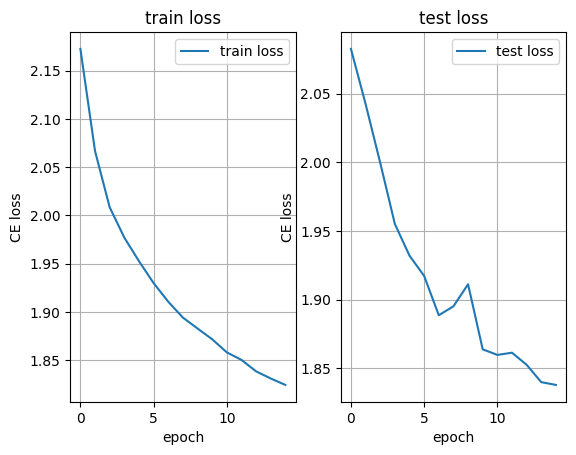

In [10]:
fig, axs = plt.subplots(1, 2)
axs[0].set_title('train loss')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('CE loss')
axs[0].grid(True)
axs[0].plot(train_loss, label='train loss')
axs[0].legend()
axs[1].set_title('test loss')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('CE loss')
axs[1].grid(True)
axs[1].plot(test_loss, label='test loss')
axs[1].legend()

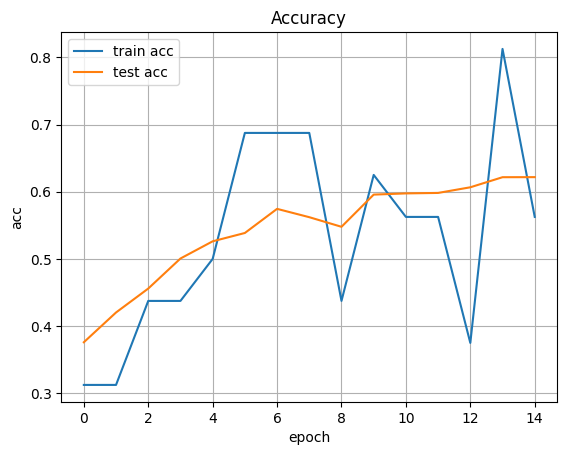

In [11]:
plt.figure(2)
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.grid(True)
plt.plot(train_acc, label='train acc')
plt.plot(test_acc, label='test acc')
plt.legend()

### Comparison of two models (one without and one with Deformable convolution)

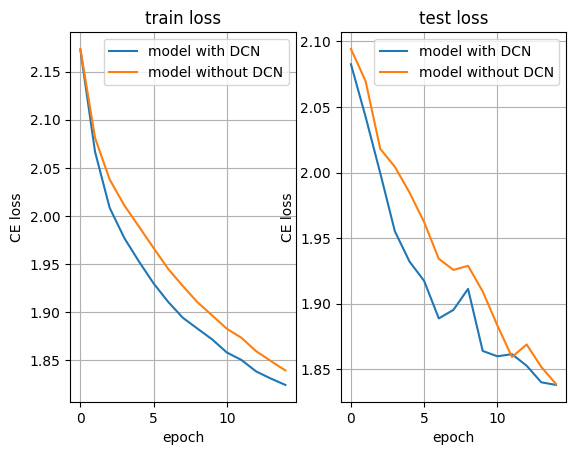

In [12]:
fig, axs = plt.subplots(1, 2)
axs[0].set_title('train loss')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('CE loss')
axs[0].grid(True)
axs[0].plot(train_loss, label='model with DCN')
axs[0].plot(train_loss_1, label='model without DCN')
axs[0].legend()
axs[1].set_title('test loss')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('CE loss')
axs[1].grid(True)
axs[1].plot(test_loss, label='model with DCN')
axs[1].plot(test_loss_1, label='model without DCN')
axs[1].legend()

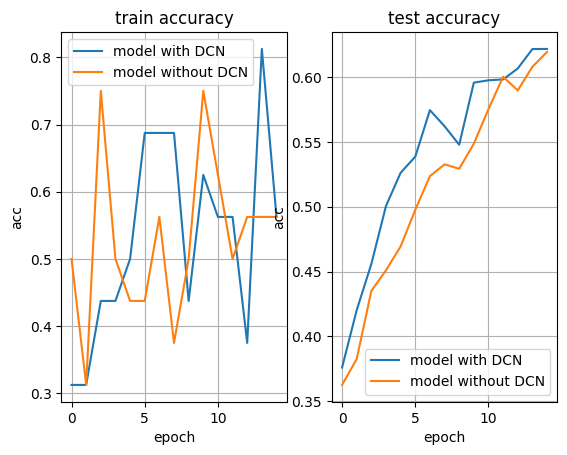

In [13]:
fig, axs = plt.subplots(1, 2)
axs[0].set_title('train accuracy')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('acc')
axs[0].grid(True)
axs[0].plot(train_acc, label='model with DCN')
axs[0].plot(train_acc_1, label='model without DCN')
axs[0].legend()
axs[1].set_title('test accuracy')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('acc')
axs[1].grid(True)
axs[1].plot(test_acc, label='model with DCN')
axs[1].plot(test_acc_1, label='model without DCN')
axs[1].legend()

In [14]:
print(f"Training Runtime for model with traditional convolution: {training_time:.2f} seconds")
print(f"Training Runtime for model with deformable convolution: {training_time_DCN:.2f} seconds")

Training Runtime for model with traditional convolution: 276.18 seconds
Training Runtime for model with deformable convolution: 386.13 seconds


As seen from the results above, the model with deformable convolution demonstrates higher accuracy compared to the model without deformable convolution. Additionally, the average loss in the model with deformable convolution is lower, indicating the efficiency of deformable convolution. However, the training runtime in the model with deformable convolution is longer than the model without deformable convolution.